In [1]:
import uproot
import awkward as ak

In [2]:
import vector

In [3]:
import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import math

In [6]:
from matplotlib.ticker import AutoMinorLocator

In [7]:
import infofile

In [8]:
lumi = 10 
fraction = 1.0
MeV = 0.001
GeV = 1.0

In [9]:
tuple_path = "./4lep/"

In [10]:
samples = {
    'data': {
        'list' : ['data_A', 'data_B', 'data_C', 'data_D'],
    },
    
    r'Background $Z,t\bar{t}$' : { 
        'list' : ['Zee', 'Zmumu', 'ttbar_lep'],
        'color' : "#6b59d3"
    },
    
    r'Background $ZZ^*$' : {
        'list' : ['llll'],
        'color' : "#00cdff"
    },
    
    r'Signal ($m_H$ = 125 GeV)' : {
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep', 'ZH125_ZZ4lep'],
        'color' : "#ff0000"
    },
    
}

In [11]:
def get_data_from_files():
    data = {}
    for s in samples:
        print('Processing'+s+'samples')
        frames = []
        for val in samples[s]['list']:
            if s == 'data': prefix = "Data/"
            else:
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root"
            temp = read_file(fileString,val)
            frames.append(temp)
        data[s] = ak.concatenate(frames)
        
    return data

In [12]:
def calc_weight(xsec_weight, events):
    return(
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON
        * events.scaleFactor_LepTRIGGER
    )

In [13]:
def get_xsec_weight(sample):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"])
    return xsec_weight

In [14]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.awk(ak.zip(dict(pt=lep_pt, eta=lep_eta, phi=lep_phi, E=lep_E)))
    return (p4[:,0] + p4[:,1] + p4[:,2] + p4[:,3]).M * MeV

def calc_quantities(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.awk(ak.zip(dict(pt=lep_pt, eta=lep_eta, phi=lep_phi, E=lep_E)))
    m4l = (p4[:,0] + p4[:,1] + p4[:,2] + p4[:,3]).M * MeV
    lep0_pt = lep_pt[0]
    lep0_eta = lep_eta[0]
    lep0_phi = lep_phi[0]
    lep0_E = lep_E[0]
    return m4l, lep0_pt, lep0_eta, lep0_phi, lep0_E

In [15]:
def cut_lep_charge(lep_charge):
    return lep_charge[:,0] + lep_charge[:,1] + lep_charge[:,2] + lep_charge[:,3] != 0

In [16]:
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:,0] + lep_type[:,1] + lep_type[:,2] + lep_type[:,3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

In [17]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    data_all = []
    
    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entries
        if 'data' not in sample: xsec_weight = get_xsec_weight(sample)
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_E','lep_charge','lep_type',
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER'],
                                 library="ak",
                                 entry_stop=numevents*fraction):
            nIn = len(data)
            
            if 'data' not in sample:
                data['totalWeight'] = calc_weight(xsec_weight, data)
            
            data = data[~cut_lep_charge(data.lep_charge)]
            
            data = data[~cut_lep_type(data.lep_type)]
            
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
            #data["mLLLL"], data["lep0_pt"], data["lep0_eta"], data["lep0_phi"], data["lep0_E"] = calc_quantities(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
            
            nOut = len(data)
            data_all.append(data)
            elapsed = time.time() - start
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s")
            
        return ak.concatenate(data_all)

In [18]:
start = time.time()
data = get_data_from_files()
elapsed = time.time() - start
print("Time taken: "+str(round(elapsed,1))+"s")

Processingdatasamples
	Processing: data_A
		 nIn: 1,	 nOut: 	0	 in 0.3s
		 nIn: 1,	 nOut: 	1	 in 0.4s
		 nIn: 1,	 nOut: 	1	 in 0.5s
		 nIn: 1,	 nOut: 	0	 in 0.6s
		 nIn: 1,	 nOut: 	1	 in 0.6s
		 nIn: 1,	 nOut: 	1	 in 0.7s
		 nIn: 1,	 nOut: 	0	 in 0.8s
		 nIn: 1,	 nOut: 	1	 in 0.9s
		 nIn: 1,	 nOut: 	1	 in 1.0s
		 nIn: 1,	 nOut: 	1	 in 1.1s
		 nIn: 1,	 nOut: 	0	 in 1.1s
		 nIn: 1,	 nOut: 	0	 in 1.2s
		 nIn: 1,	 nOut: 	0	 in 1.3s
		 nIn: 1,	 nOut: 	0	 in 1.4s
		 nIn: 1,	 nOut: 	1	 in 1.4s
		 nIn: 1,	 nOut: 	1	 in 1.5s
		 nIn: 1,	 nOut: 	1	 in 1.6s
		 nIn: 1,	 nOut: 	1	 in 1.7s
		 nIn: 1,	 nOut: 	1	 in 1.8s
		 nIn: 1,	 nOut: 	1	 in 1.8s
		 nIn: 1,	 nOut: 	1	 in 1.9s
		 nIn: 1,	 nOut: 	1	 in 2.0s
		 nIn: 1,	 nOut: 	1	 in 2.1s
		 nIn: 1,	 nOut: 	1	 in 2.2s
		 nIn: 1,	 nOut: 	1	 in 2.3s
		 nIn: 1,	 nOut: 	1	 in 2.3s
		 nIn: 1,	 nOut: 	0	 in 2.4s
		 nIn: 1,	 nOut: 	1	 in 2.5s
		 nIn: 1,	 nOut: 	0	 in 2.6s
		 nIn: 1,	 nOut: 	1	 in 2.7s
		 nIn: 1,	 nOut: 	1	 in 2.7s
		 nIn: 1,	 nOut: 	0	 in 2.8

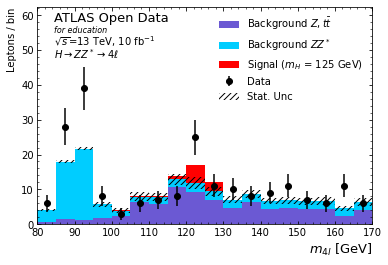

In [20]:
xmin = 80 * GeV
xmax = 170 * GeV
step_size = 5 * GeV
    
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size)
    
bin_centres = np.arange(start=xmin+step_size/2, stop=xmax+step_size/2, step=step_size)

#data

data_x,_ = np.histogram(ak.to_numpy(data['data']['mllll']), bins=bin_edges)

data_x_errors = np.sqrt(data_x)


#signal

signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)']['mllll'])
signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color']

#background
mc_x = []
mc_weights = []
mc_colors = []
mc_labels = []


for s in samples:
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']:
        mc_x.append(ak.to_numpy(data[s]['mllll']))
        mc_weights.append(ak.to_numpy(data[s].totalWeight))      
        mc_colors.append(samples[s]['color'])
        mc_labels.append(s)

main_axes = plt.gca()

#Exp Data
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data')

#background
mc_heights = main_axes.hist(mc_x, bins=bin_edges, weights=mc_weights, stacked=True, color=mc_colors, label=mc_labels)

#Higgs  
mc_x_tot = mc_heights[0][-1]

main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, weights=signal_weights, color=signal_color, label=r'Signal ($m_H$ = 125 GeV)')

#Stat Unc
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot-mc_x_err, color='none', hatch="////",width=step_size, label='Stat. Unc')


#####################################################################    
main_axes.set_xlim(left=xmin, right=xmax)
    
main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    
main_axes.tick_params(which='both', direction='in', top=True, right=True)
    
main_axes.set_xlabel('$m_{4l}$ [GeV]', fontsize=13, x=1, horizontalalignment='right')
    
main_axes.set_ylabel('Leptons / bin', y=1, horizontalalignment='right')
    
main_axes.set_ylim(bottom=0, top=np.amax(data_x)*1.6)
    
main_axes.yaxis.set_minor_locator(AutoMinorLocator())
    
plt.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    
plt.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    
plt.text(0.05, 0.82, '$\sqrt{s}$=13 TeV, 10 fb$^{-1}$', transform=main_axes.transAxes)
    
plt.text(0.05, 0.76, r'$H \rightarrow ZZ^* \rightarrow 4\ell$', transform=main_axes.transAxes)   

main_axes.legend(frameon=False)

#plt.savefig('mllll')